In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set parameters
IMAGE_SIZE = (299, 299)

In [5]:
train_files = []
mask_files = glob('/content/drive/MyDrive/masks_dataset/*_mask*')
for i in mask_files:
     train_files.append(i.replace('_mask', ''))

In [6]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))


In [7]:
df.head(3000)

,image_path,mask_path,mask
0,/content/drive/MyDrive/masks_dataset/y549.jpg,/content/drive/MyDrive/masks_dataset/y549_mask...,1
1,/content/drive/MyDrive/masks_dataset/y55.jpg,/content/drive/MyDrive/masks_dataset/y55_mask.jpg,1
2,/content/drive/MyDrive/masks_dataset/y550.jpg,/content/drive/MyDrive/masks_dataset/y550_mask...,1
3,/content/drive/MyDrive/masks_dataset/y551.jpg,/content/drive/MyDrive/masks_dataset/y551_mask...,1
4,/content/drive/MyDrive/masks_dataset/y552.jpg,/content/drive/MyDrive/masks_dataset/y552_mask...,1
...,...,...,...
2995,/content/drive/MyDrive/masks_dataset/no144.jpg,/content/drive/MyDrive/masks_dataset/no144_mas...,0
2996,/content/drive/MyDrive/masks_dataset/no1440.jpg,/content/drive/MyDrive/masks_dataset/no1440_ma...,0
2997,/content/drive/MyDrive/masks_dataset/no1441.jpg,/content/drive/MyDrive/masks_dataset/no1441_ma...,0
2998,/content/drive/MyDrive/masks_dataset/no1442.jpg,/content/drive/MyDrive/masks_dataset/no1442_ma...,0


In [8]:
df['mask'].value_counts()

1    1500
0    1500
Name: mask, dtype: int64

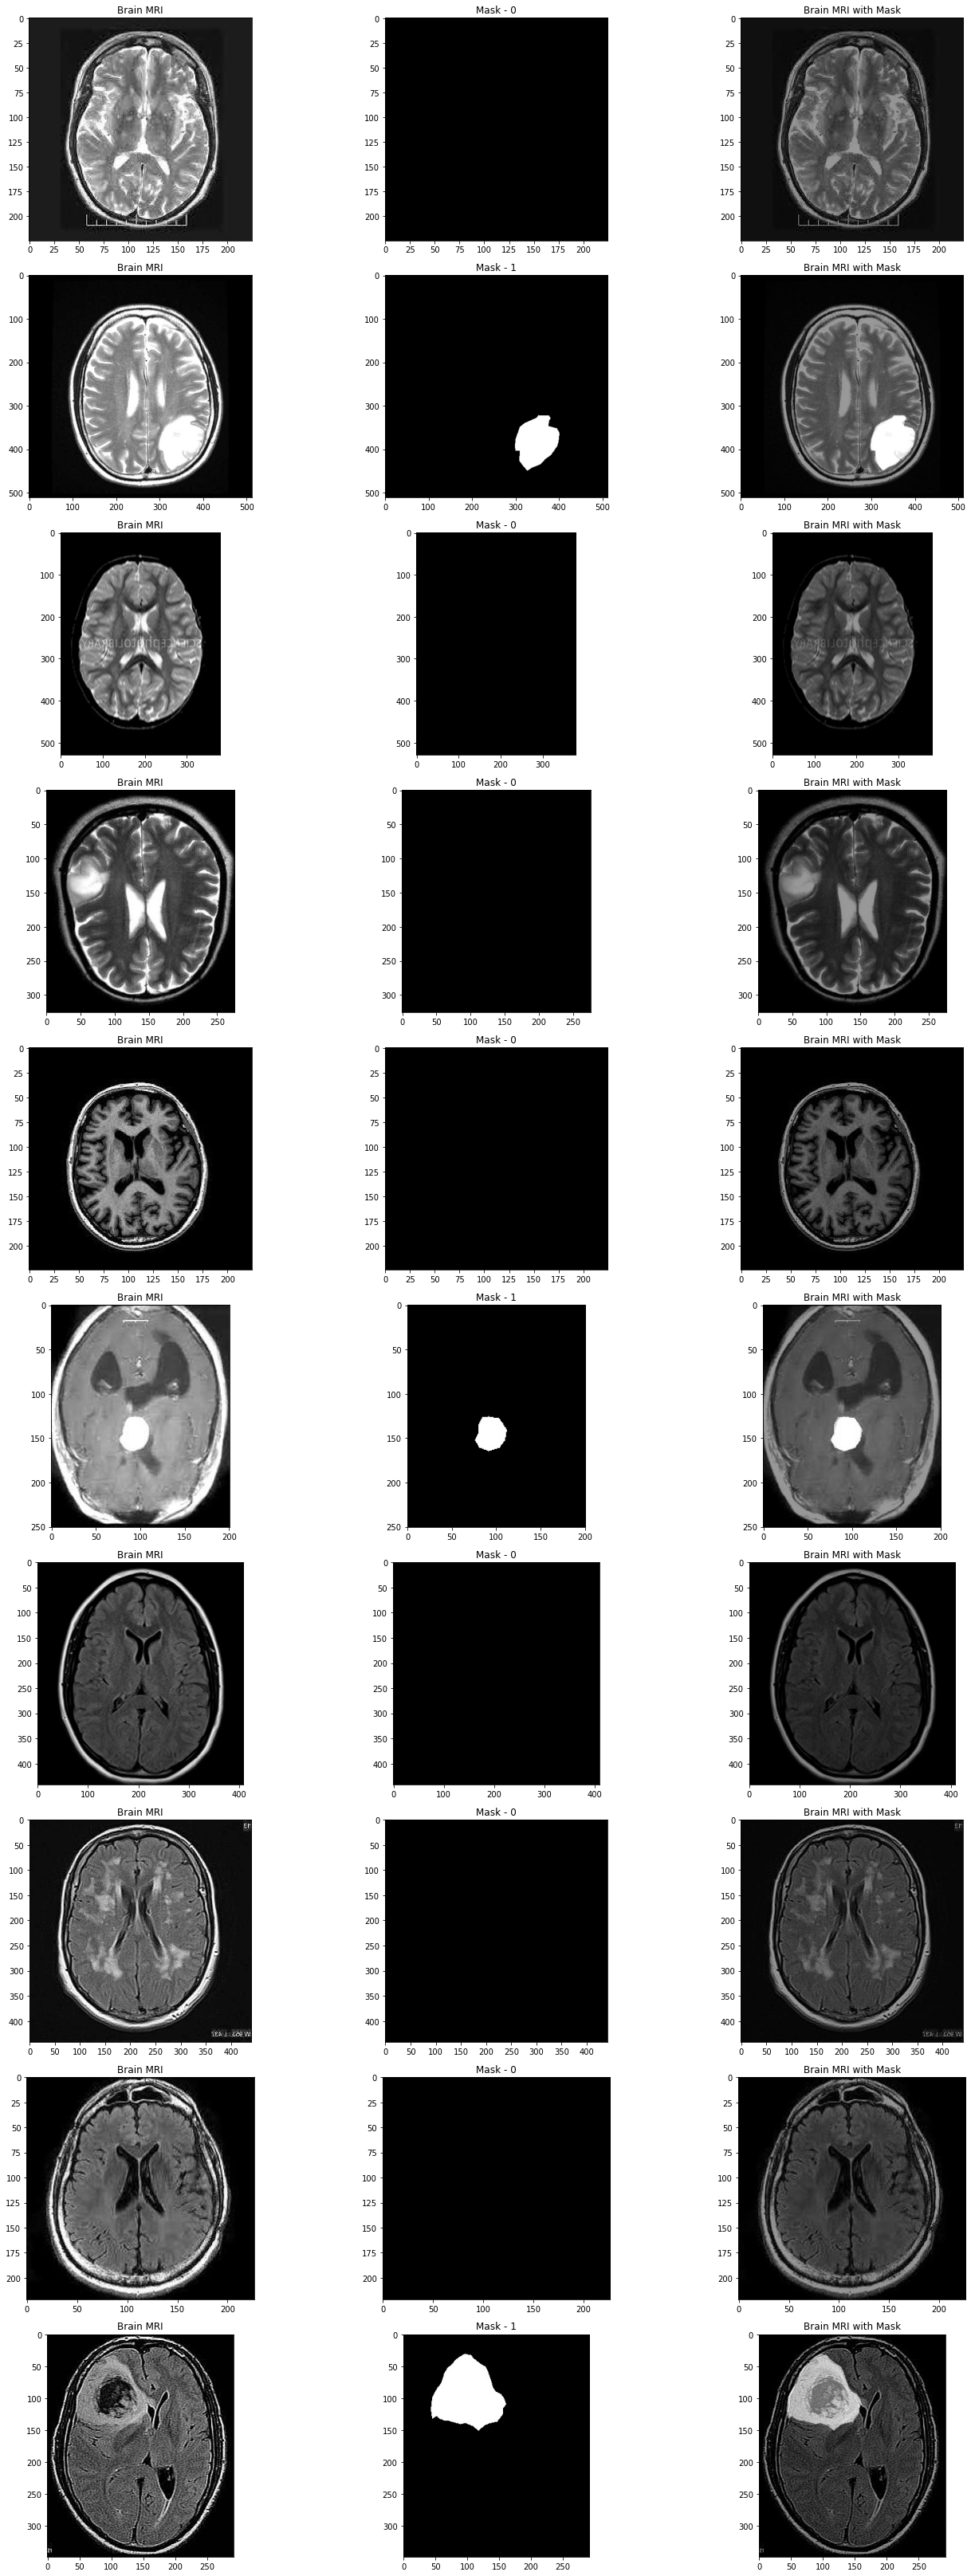

In [9]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

In [10]:
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3000 non-null   object
 1   mask_path   3000 non-null   object
 2   mask        3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2167, 3)
(383, 3)
(450, 3)


In [12]:
datagen = ImageDataGenerator(rescale=1/255.)
train_generator = datagen.flow_from_dataframe(df_train, 
                                             x_col='image_path',
                                             y_col='mask',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                             target_size=IMAGE_SIZE)
validation_generator = datagen.flow_from_dataframe(df_val,
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True,
                                                  target_size=IMAGE_SIZE)
test_generator = datagen.flow_from_dataframe(df_test,
                                            x_col='image_path',
                                            y_col='mask',
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=False,
                                            target_size=IMAGE_SIZE)

Found 2167 validated image filenames belonging to 2 classes.
Found 383 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


In [ ]:

base_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

clf_model_inception = Model(base_model.input, outputs=x)
clf_model_inception.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
clf_model_inception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='clf_model_vgg16.hdf5',
                            verbose=1,
                            save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=5,
                             min_denta=0.0001,
                             factor=0.2)
my_callbacks = [es, checkpoint, reduce_lr]

In [ ]:
history = clf_model_inception.fit(train_generator,
                   epochs=30,
                   steps_per_epoch= train_generator.n // train_generator.batch_size,
                   validation_data=validation_generator,
                   validation_steps = validation_generator.n // validation_generator.batch_size,
                   callbacks=[checkpoint, es])

Epoch 1/30
67/67 [==============================] - 556s 8s/step - loss: 0.3584 - accuracy: 0.8749 - val_loss: 26.5790 - val_accuracy: 0.4801

Epoch 00001: val_loss improved from inf to 26.57897, saving model to clf_model_vgg16.hdf5
Epoch 2/30
67/67 [==============================] - 68s 1s/step - loss: 0.1591 - accuracy: 0.9550 - val_loss: 397.7884 - val_accuracy: 0.4858

Epoch 00002: val_loss did not improve from 26.57897
Epoch 3/30
67/67 [==============================] - 68s 1s/step - loss: 0.0748 - accuracy: 0.9803 - val_loss: 2.6103 - val_accuracy: 0.6903

Epoch 00003: val_loss improved from 26.57897 to 2.61027, saving model to clf_model_vgg16.hdf5
Epoch 4/30
67/67 [==============================] - 68s 1s/step - loss: 0.0570 - accuracy: 0.9766 - val_loss: 1.6795 - val_accuracy: 0.7557

Epoch 00004: val_loss improved from 2.61027 to 1.67950, saving model to clf_model_vgg16.hdf5
Epoch 5/30
67/67 [==============================] - 68s 1s/step - loss: 0.0989 - accuracy: 0.9686 - val

In [ ]:
clf_model_inception.save('/content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_inception')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_inception/assets


Accuracy: 99.556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       215
           1       1.00      1.00      1.00       235

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



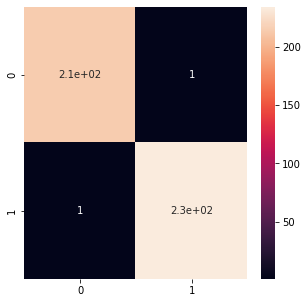

In [ ]:
import seaborn as sns
preds = clf_model_inception.predict(test_generator)
preds = np.argmax(preds, axis=1)
labels = np.asarray(df_test['mask']).astype('int')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(labels, preds)
print("Accuracy: {:.3f}".format(accuracy*100))

cm = confusion_matrix(labels, preds)
report = classification_report(labels, preds, labels=[0,1])
print(report)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)

In [15]:
from keras.preprocessing.image import load_img, img_to_array

In [14]:
model= tf.keras.models.load_model('/content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_inception')

In [16]:
model.evaluate(test_generator)

15/15 [==============================] - 95s 4s/step - loss: 0.0233 - accuracy: 0.9956


[0.023298712447285652, 0.995555579662323]

In [112]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
def load_image(img_path, show=True,img_size=299):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    return img_tensor

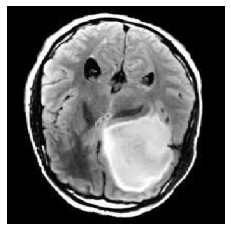

Modèle: inceptionv3 avec mask
Tumor detected
Accucracy: 100.0 %


In [166]:
img_path = '/content/y55.jpg'   
new_image = load_image(img_path)
pred = model.predict(new_image)
preds = np.argmax(pred, axis=1)
print('Modèle: inceptionv3 avec mask')
if(preds[0]<0.5):
  print("No tumor detected")
  print("Accucracy:",round(pred[0][0]*100,5),"%")
else:
  print("Tumor detected")
  print("Accucracy:",round(pred[0][1]*100,5),"%")
